# Experimentación - DryGrEncoder



## 1. Obtención de datos



In [ ]:
import torch
print(torch.__version__)

In [ ]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [ ]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [ ]:
results_save_path = "./results"
name_model = "DryGrEncoder"

In [ ]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

## Funciones auxiliares - entrenamiento

In [ ]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.dygrae import DyGrEncoder
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel, TrainerDryGrEncoder
from utils import trainer
dtype = torch.float
device = torch.device("mps")

In [ ]:
from importlib import reload  # Python 3.4+
import utils.dygrae
dygrae = reload(utils.dygrae)


In [ ]:
from importlib import reload  # Python 3.4+
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerModel, TrainerDryGrEncoder


In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, num_conv=1,  num_lstm=1, aggr="mean"):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        super(RecurrentGCN, self).__init__()
        self.recurrent = dygrae.DyGrEncoder(conv_out_channels=100, conv_num_layers=num_conv, conv_aggr=aggr, lstm_out_channels=self.n_features, lstm_num_layers=num_lstm)
        self.linear = torch.nn.Linear(self.n_features, n_target)
        self.h =None

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h)
        h = self.linear(h)
        self.h = h
        return h, h_0, c_0


In [ ]:
import itertools


def entrenar_y_evaluar_modelos(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]


    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for aggr, conv, lstm in tqdm(list(itertools.product(param_grid["aggr"], param_grid["conv"], param_grid["lstm"]))):
        model = RecurrentGCN("DyGrEncoder", node_features=n_features, node_count=n_nodes, n_target=n_target, num_conv=conv, num_lstm=lstm, aggr=aggr)
        trainer_bt = TrainerDryGrEncoder(model, dataset,device, f"./results/{problem}", dataloader_params)


        losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer_bt.test()

        results_intermedio = {
            "Aggr": aggr,
            "Conv": conv,
            "LSTM": lstm,
            "Loss_final": losses[-1],
            "R2_eval": np.mean(r2scores[-1]),
            "Loss_eval": np.mean(eval_losses[-1]),
            "R2_tst": np.mean(r2score_tst),
            "Loss_tst": np.mean(losses_tst),
            "Loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer_bt
            mejores_parametros = {'aggr': aggr, 'conv': conv, 'lstm': lstm}
            mejores_resultados = results_intermedio

        print("Parámetros: ", aggr, conv, lstm)
        print("Resultados: ", resultados_list[-1])

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_gt


## Prueba - predicción por tipos

In [ ]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [ ]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)

 

In [ ]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5




#### Sencilla 

In [ ]:

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")


trainer_gt = TrainerDryGrEncoder(model, dataset_gt, device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores = trainer_gt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()


In [ ]:
plot_predictions(predictions, real, n_target, 1, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [ ]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

In [ ]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [ ]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [ ]:
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [ ]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)

### Bus trip

In [ ]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




In [ ]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5




#### Sencilla 

In [ ]:

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")


trainer_bt = TrainerDryGrEncoder(model, dataset_bt, device, f"./results/{problem_bt}", dataloader_params2)

losses,eval_losses, r2scores = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_bt.test()


In [ ]:
plot_predictions(predictions, real, n_target, 1, n_div_bt, problem_bt)

#### Ajuste de parámetros 

In [ ]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

trainer_bt,params_bt, resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

In [ ]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [ ]:
_,_,_, predictions_bt_ajuste,real_bt_ajuste = trainer_bt.test()
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 1, n_div_bt, problem_bt)

In [ ]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params = params_bt)

### Bus fault

In [ ]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)


In [ ]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5




#### Sencilla 

In [ ]:

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")


trainer_bf = TrainerDryGrEncoder(model, dataset_bf, device, f"./results/{problem_bf}", dataloader_params2)

losses,eval_losses, r2scores = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_bf.test()


In [ ]:
plot_predictions(predictions, real, n_target, 1, n_div_bf, problem_bf)

#### Ajuste de parámetros 

In [16]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

trainer_bf,params_bf, resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

Epoch 29/30 | Train Loss: 0.0164 | Eval Loss: 0.0250 | Eval R2: -1.8704 | 
Epoch 30/30 | Train Loss: 0.0164 | Eval Loss: 0.0249 | Eval R2: -1.8370 | 

==================== TEST INFO ===================



 38%|███▊      | 3/8 [21:37<38:11, 458.38s/it]

preds:  (1, 23, 20)
test loss: 0.016618, test r2score -0.738520
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'Loss_final': 0.016367493197321892, 'R2_eval': -1.8370355367660522, 'Loss_eval': 0.024916529655456543, 'R2_tst': -0.7385200071318732, 'Loss_tst': 0.01661797985434532, 'Loss_nodes': [[0.005007174331694841, 0.006604798603802919, 0.006935759913176298, 0.008734490722417831, 0.009672635234892368, 0.010205881670117378, 0.014032398350536823, 0.014446472749114037, 0.016780732199549675, 0.017153697088360786, 0.018110569566488266, 0.020665166899561882, 0.022239521145820618, 0.023275142535567284, 0.02314971387386322, 0.021405380219221115, 0.021939735859632492, 0.02490917406976223, 0.023034049198031425, 0.02405714802443981]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2237 | Eval Loss: 0.1325 | Eval R2: -11.185

 50%|█████     | 4/8 [31:57<34:49, 522.27s/it]

preds:  (1, 23, 20)
test loss: 0.017012, test r2score -0.708820
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'Loss_final': 0.017301911488175392, 'R2_eval': -1.9144209623336792, 'Loss_eval': 0.0263996385037899, 'R2_tst': -0.708820087504879, 'Loss_tst': 0.017011962831020355, 'Loss_nodes': [[0.005711399018764496, 0.007426468189805746, 0.007933836430311203, 0.009483901783823967, 0.010088777169585228, 0.010607665404677391, 0.014545159414410591, 0.014626205898821354, 0.01692141406238079, 0.01727827452123165, 0.01855696737766266, 0.021152883768081665, 0.022600239142775536, 0.02308894693851471, 0.023470956832170486, 0.021837208420038223, 0.02208028919994831, 0.024776579812169075, 0.023261504247784615, 0.024790598079562187]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1632 | Eval Loss: 0.0792 | Eval R2: -8.7120 | 


 62%|██████▎   | 5/8 [38:52<24:10, 483.44s/it]

preds:  (1, 23, 20)
test loss: 0.016410, test r2score -0.664772
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'Loss_final': 0.015078329481184483, 'R2_eval': -1.7005923986434937, 'Loss_eval': 0.024213867262005806, 'R2_tst': -0.6647721491061731, 'Loss_tst': 0.01641019620001316, 'Loss_nodes': [[0.004521758761256933, 0.006362278014421463, 0.006998791359364986, 0.008588695898652077, 0.009553387761116028, 0.009777683764696121, 0.01378877367824316, 0.013777765445411205, 0.01567390002310276, 0.017207851633429527, 0.01781051978468895, 0.020627519115805626, 0.022166883572936058, 0.023462790995836258, 0.023173417896032333, 0.02163725160062313, 0.02195112407207489, 0.02471260540187359, 0.023096423596143723, 0.023314548656344414]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2160 | Eval Loss: 0.1144 | Eval R2: -12.4892

 75%|███████▌  | 6/8 [46:32<15:51, 475.63s/it]

preds:  (1, 23, 20)
test loss: 0.018390, test r2score -1.200847
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'Loss_final': 0.01664142869412899, 'R2_eval': -2.5746779441833496, 'Loss_eval': 0.024981161579489708, 'R2_tst': -1.2008470675717298, 'Loss_tst': 0.018389998003840446, 'Loss_nodes': [[0.006579768843948841, 0.008858049288392067, 0.009418759495019913, 0.01080465130507946, 0.011839477345347404, 0.012626023963093758, 0.016175448894500732, 0.016796503216028214, 0.01872134581208229, 0.01883854530751705, 0.020658355206251144, 0.02283474989235401, 0.024250704795122147, 0.024963967502117157, 0.024458415806293488, 0.022606827318668365, 0.023094313219189644, 0.025603629648685455, 0.023575911298394203, 0.02509445510804653]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1771 | Eval Loss: 0.0786 | Eval R2: -8.3763

 88%|████████▊ | 7/8 [56:52<08:42, 522.77s/it]

preds:  (1, 23, 20)
test loss: 0.016525, test r2score -0.640854
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'Loss_final': 0.015701530501246452, 'R2_eval': -1.718775987625122, 'Loss_eval': 0.025019578635692596, 'R2_tst': -0.6408536041223238, 'Loss_tst': 0.016524862498044968, 'Loss_nodes': [[0.004892085213214159, 0.0067061916925013065, 0.007154643069952726, 0.008627722039818764, 0.00994640588760376, 0.010031737387180328, 0.013957017101347446, 0.014640738256275654, 0.016639284789562225, 0.017418943345546722, 0.017762651666998863, 0.020347990095615387, 0.02226463332772255, 0.022859612479805946, 0.022931398823857307, 0.02125079743564129, 0.02157239057123661, 0.024599704891443253, 0.022960303351283073, 0.02393302693963051]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2141 | Eval Loss: 0.1209 | Eval R2: -12.22

100%|██████████| 8/8 [1:08:57<00:00, 517.24s/it]

preds:  (1, 23, 20)
test loss: 0.016877, test r2score -1.110285
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'Loss_final': 0.016196614131331444, 'R2_eval': -2.317375898361206, 'Loss_eval': 0.02480897307395935, 'R2_tst': -1.1102850017165522, 'Loss_tst': 0.01687660999596119, 'Loss_nodes': [[0.006243175361305475, 0.007742325309664011, 0.008438310585916042, 0.010031983256340027, 0.010674127377569675, 0.01115630753338337, 0.014974793419241905, 0.014791104011237621, 0.01695021614432335, 0.01764628104865551, 0.018069136887788773, 0.02049212157726288, 0.022524449974298477, 0.022343216463923454, 0.02260233275592327, 0.020972473546862602, 0.02137625776231289, 0.023829014971852303, 0.02242058888077736, 0.02425404079258442]]}


In [17]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.016410, test r2score -0.664772


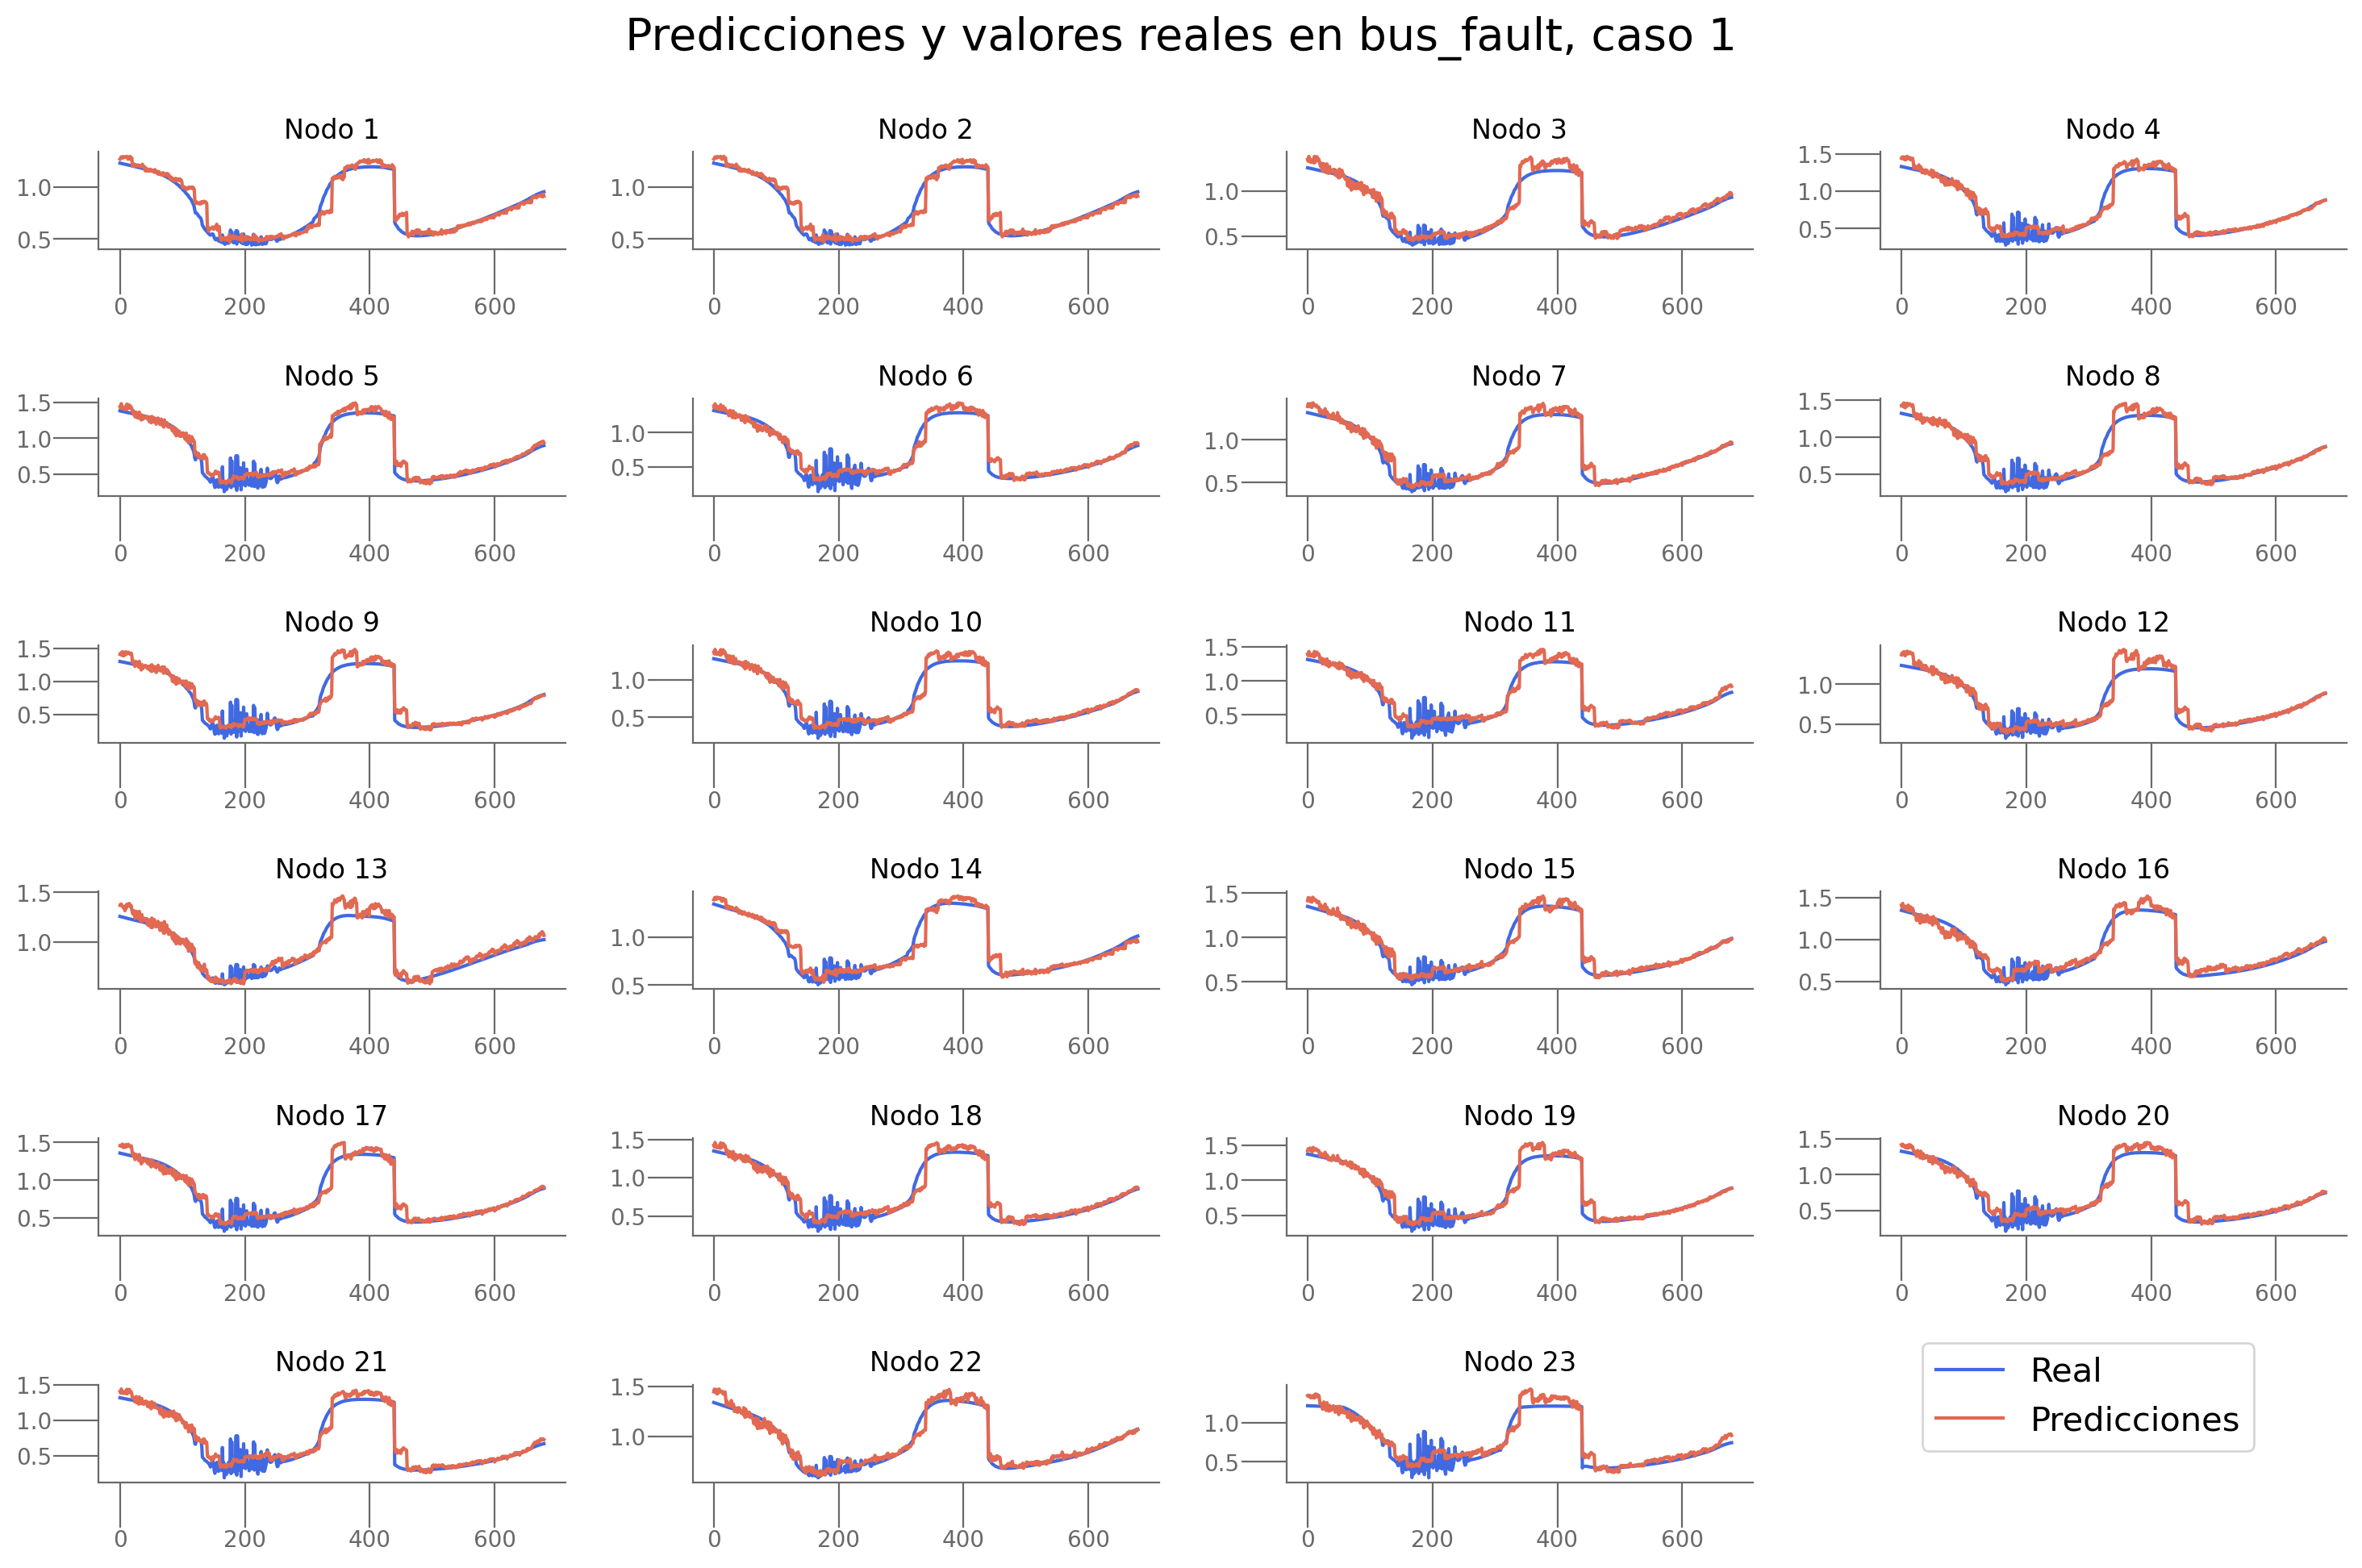

In [19]:
_,_,_, predictions_bf_ajuste,real_bf_ajuste = trainer_bf.test()
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 1, n_div_bf, problem_bf)

In [20]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params = params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                  Params  \
0          LSTM                                     NaN   
1  LSTM_NOBATCH                                     NaN   
2     MPNN_LSTM     {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder  {'aggr': 'mean', 'conv': 1, 'lstm': 1}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.664772   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0107881  0.01006583 0.01300934 0.01969145 0...  0.541346   0.024664   
1  [0.01527361 0.01028231 0.01348895 0.01959247 0... -2.717829   0.025920   
2  [[0.00348817 0.00553344 0

### Branch Fault

In [21]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [22]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5




#### Sencilla 

In [24]:

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")


trainer_brf = TrainerDryGrEncoder(model, dataset_brf, device, f"./results/{problem_brf}", dataloader_params2)

losses,eval_losses, r2scores = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_brf.test()



==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================



KeyboardInterrupt: 

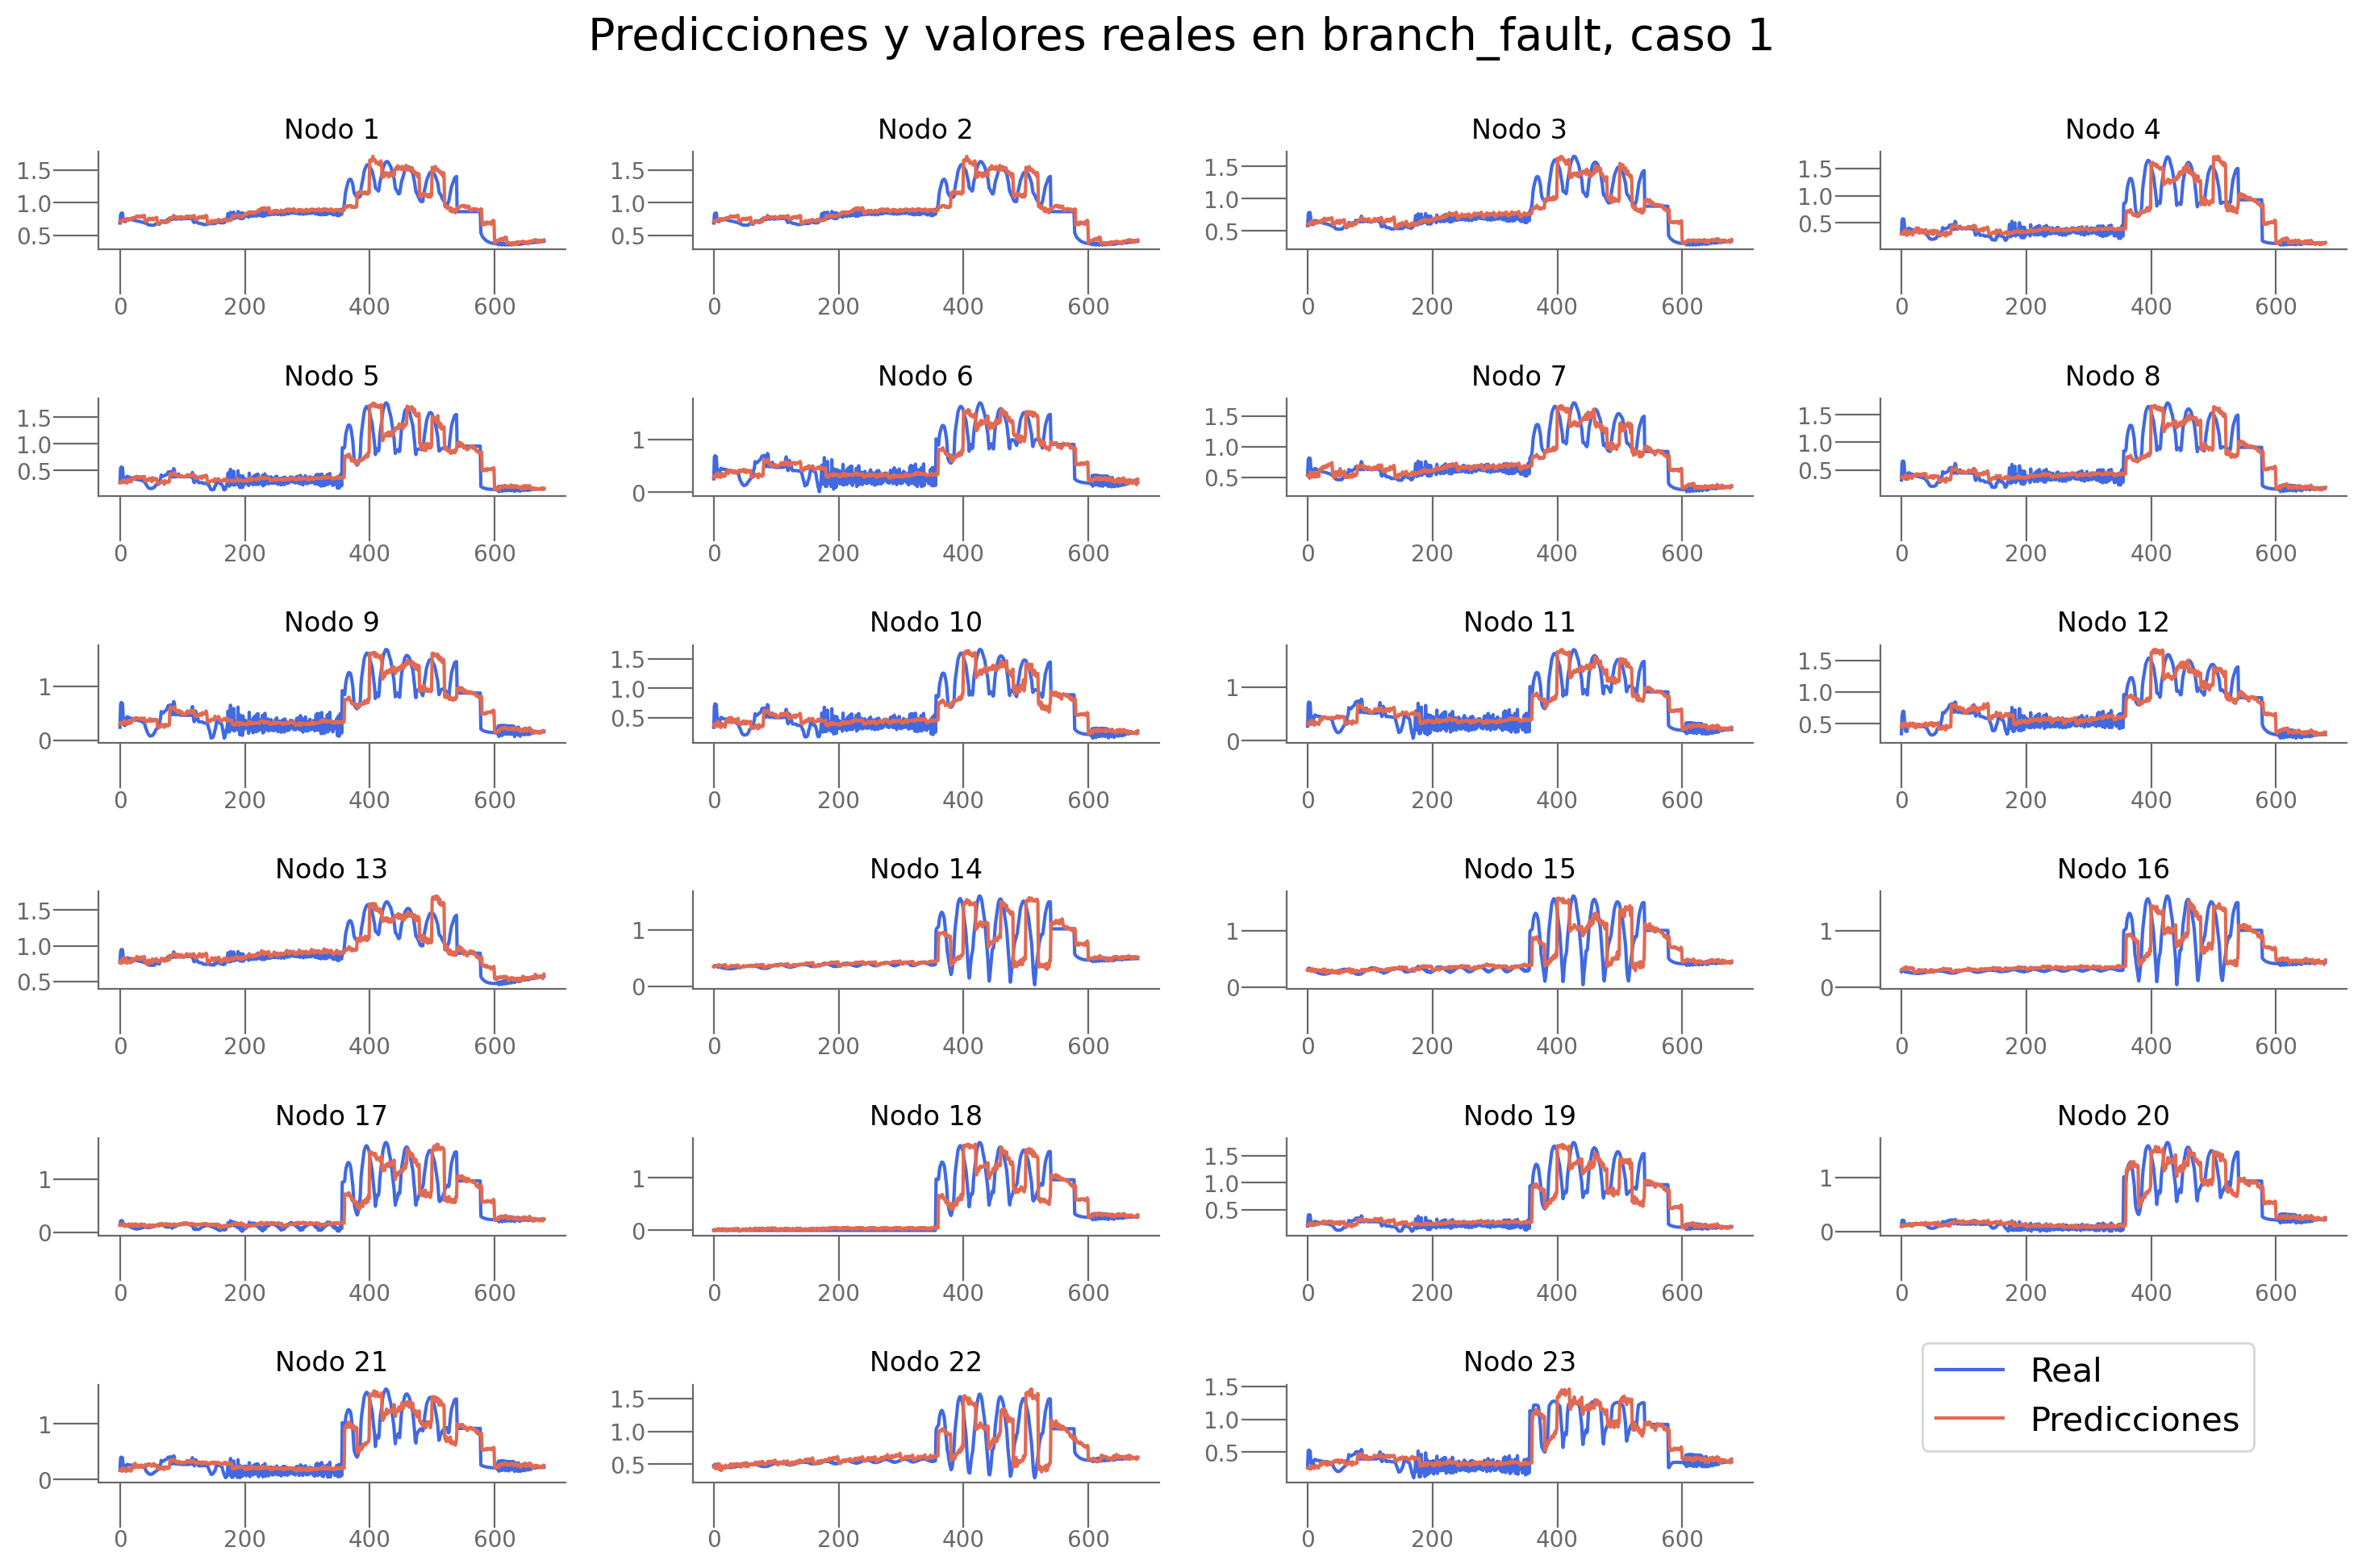

In [25]:
plot_predictions(predictions, real, n_target, 1, n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [26]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

trainer_brf,params_brf, resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1359 | Eval Loss: 0.0735 | Eval R2: -7.2356 | 
Epoch 2/30 | Train Loss: 0.0367 | Eval Loss: 0.0390 | Eval R2: -3.7065 | 
Epoch 3/30 | Train Loss: 0.0279 | Eval Loss: 0.0356 | Eval R2: -3.8818 | 
Epoch 4/30 | Train Loss: 0.0248 | Eval Loss: 0.0325 | Eval R2: -3.5552 | 
Epoch 5/30 | Train Loss: 0.0235 | Eval Loss: 0.0319 | Eval R2: -3.4304 | 
Epoch 6/30 | Train Loss: 0.0228 | Eval Loss: 0.0310 | Eval R2: -3.3677 | 
Epoch 7/30 | Train Loss: 0.0226 | Eval Loss: 0.0312 | Eval R2: -3.3916 | 
Epoch 8/30 | Train Loss: 0.0224 | Eval Loss: 0.0307 | Eval R2: -3.2441 | 
Epoch 9/30 | Train Loss: 0.0213 | Eval Loss: 0.0302 | Eval R2: -3.2357 | 
Epoch 10/30 | Train Loss: 0.0209 | Eval Loss: 0.0298 | Eval R2: -3.3468 | 
Epoch 11/30 | Train Loss: 0.0210 | Eval Loss: 0.0309 | Eval R2: -3.3498 | 
Epoch 12/30 

 12%|█▎        | 1/8 [07:49<54:44, 469.24s/it]

preds:  (1, 23, 20)
test loss: 0.020580, test r2score -1.669938
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'Loss_final': 0.018094424158334732, 'R2_eval': -2.772604465484619, 'Loss_eval': 0.026631543412804604, 'R2_tst': -1.6699382658015423, 'Loss_tst': 0.020580396056175232, 'Loss_nodes': [[0.004804676398634911, 0.008133996278047562, 0.015444275923073292, 0.013769345358014107, 0.012435327284038067, 0.013287359848618507, 0.016389215365052223, 0.022985605522990227, 0.023143509402871132, 0.020020483061671257, 0.01968655176460743, 0.021839655935764313, 0.029203306883573532, 0.028162088245153427, 0.024957936257123947, 0.02329510822892189, 0.026311781257390976, 0.0313902273774147, 0.030089285224676132, 0.026258205994963646]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1722 | Eval Loss: 0.1106 | Eval R2: -11.0216

 25%|██▌       | 2/8 [16:37<50:24, 504.16s/it]

preds:  (1, 23, 20)
test loss: 0.023213, test r2score -1.937843
Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'Loss_final': 0.018973316997289658, 'R2_eval': -2.864100933074951, 'Loss_eval': 0.028983954340219498, 'R2_tst': -1.9378426075213864, 'Loss_tst': 0.02321290224790573, 'Loss_nodes': [[0.0070711905136704445, 0.009593229740858078, 0.01609315536916256, 0.017003949731588364, 0.01491466537117958, 0.0157537292689085, 0.01905539259314537, 0.02484520897269249, 0.02616938203573227, 0.022728778421878815, 0.02237573266029358, 0.024513140320777893, 0.03217236325144768, 0.03217386454343796, 0.02815413847565651, 0.026553133502602577, 0.029517918825149536, 0.03248218819499016, 0.033829838037490845, 0.02925701253116131]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1535 | Eval Loss: 0.0923 | Eval R2: -8.6286 | 
Epoch 

 38%|███▊      | 3/8 [28:14<49:19, 591.95s/it]

preds:  (1, 23, 20)
test loss: 0.023645, test r2score -2.040652
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'Loss_final': 0.019973808899521828, 'R2_eval': -3.15645694732666, 'Loss_eval': 0.02941100485622883, 'R2_tst': -2.0406521287193815, 'Loss_tst': 0.023645352572202682, 'Loss_nodes': [[0.007114897947758436, 0.010372690856456757, 0.015926284715533257, 0.019247211515903473, 0.01531597226858139, 0.016215089708566666, 0.019264398142695427, 0.024248410016298294, 0.028122812509536743, 0.022752689197659492, 0.02318340353667736, 0.02512725256383419, 0.03210566192865372, 0.0332692451775074, 0.028584886342287064, 0.02621457539498806, 0.02900346741080284, 0.0325278602540493, 0.03556514158844948, 0.028745200484991074]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1823 | Eval Loss: 0.1297 | Eval R2: -12.5641 | 
Epoch

 50%|█████     | 4/8 [39:54<42:19, 634.84s/it]

preds:  (1, 23, 20)
test loss: 0.022309, test r2score -1.979597
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'Loss_final': 0.01950696110725403, 'R2_eval': -2.989520311355591, 'Loss_eval': 0.028253531083464622, 'R2_tst': -1.9795970425695488, 'Loss_tst': 0.02230905368924141, 'Loss_nodes': [[0.006349371746182442, 0.009617863222956657, 0.014802002348005772, 0.01714218221604824, 0.014136599376797676, 0.015333679504692554, 0.018155479803681374, 0.023677177727222443, 0.025830084457993507, 0.021668819710612297, 0.021487288177013397, 0.023913530632853508, 0.030006853863596916, 0.03115316480398178, 0.02668493427336216, 0.025415737181901932, 0.02830953150987625, 0.03169821575284004, 0.03293291851878166, 0.02786567248404026]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1360 | Eval Loss: 0.0750 | Eval R2: -7.3273 | 
Ep

 62%|██████▎   | 5/8 [48:41<29:47, 595.97s/it]

preds:  (1, 23, 20)
test loss: 0.021237, test r2score -1.764607
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'Loss_final': 0.017451919615268707, 'R2_eval': -2.781355619430542, 'Loss_eval': 0.02676542103290558, 'R2_tst': -1.7646069259739672, 'Loss_tst': 0.021236995235085487, 'Loss_nodes': [[0.00496312603354454, 0.008217066526412964, 0.01426347903907299, 0.01158881839364767, 0.012192373163998127, 0.013861197046935558, 0.016626182943582535, 0.023970330134034157, 0.022180145606398582, 0.020411981269717216, 0.021254632622003555, 0.023383455350995064, 0.031061407178640366, 0.028408914804458618, 0.02643243782222271, 0.02580471895635128, 0.028349338099360466, 0.03249736875295639, 0.031237643212080002, 0.028035294264554977]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1715 | Eval Loss: 0.1109 | Eval R2: -11.2473 

 75%|███████▌  | 6/8 [58:32<19:48, 594.26s/it]

preds:  (1, 23, 20)
test loss: 0.021318, test r2score -1.478490
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'Loss_final': 0.018040813505649567, 'R2_eval': -2.611250400543213, 'Loss_eval': 0.027516113594174385, 'R2_tst': -1.4784903066062867, 'Loss_tst': 0.021317942067980766, 'Loss_nodes': [[0.0055427756160497665, 0.00861543882638216, 0.014735618606209755, 0.014380310662090778, 0.013271033763885498, 0.014248817227780819, 0.017125988379120827, 0.023615390062332153, 0.023319536820054054, 0.020957862958312035, 0.02037409134209156, 0.022452231496572495, 0.029714304953813553, 0.028862135484814644, 0.025986267253756523, 0.024756725877523422, 0.027777809649705887, 0.031033916398882866, 0.03175049275159836, 0.02783811092376709]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1520 | Eval Loss: 0.0856 | Eval R2: -8.24

 88%|████████▊ | 7/8 [1:12:03<11:04, 664.97s/it]

preds:  (1, 23, 20)
test loss: 0.022333, test r2score -1.907087
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'Loss_final': 0.01974720135331154, 'R2_eval': -2.861173152923584, 'Loss_eval': 0.028698669746518135, 'R2_tst': -1.907086575977146, 'Loss_tst': 0.022333037108182907, 'Loss_nodes': [[0.005824635736644268, 0.008911266922950745, 0.013998611830174923, 0.01583153009414673, 0.014197374694049358, 0.01455194316804409, 0.017839405685663223, 0.023594781756401062, 0.026004917919635773, 0.02191651426255703, 0.021939057856798172, 0.023846779018640518, 0.03115270286798477, 0.0317823700606823, 0.027068516239523888, 0.025797171518206596, 0.028474977239966393, 0.032410141080617905, 0.033493030816316605, 0.028025023639202118]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1786 | Eval Loss: 0.1242 | Eval R2: -12.4407 |

100%|██████████| 8/8 [1:27:59<00:00, 659.93s/it]

preds:  (1, 23, 20)
test loss: 0.022025, test r2score -2.195774
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'Loss_final': 0.01830805465579033, 'R2_eval': -3.0034852027893066, 'Loss_eval': 0.028093893080949783, 'R2_tst': -2.1957741350707494, 'Loss_tst': 0.02202531136572361, 'Loss_nodes': [[0.0057951947674155235, 0.00900676567107439, 0.014358134008944035, 0.01657838374376297, 0.01332962978631258, 0.014559782110154629, 0.017636222764849663, 0.02352083846926689, 0.025474440306425095, 0.021408429369330406, 0.021339314058423042, 0.023354627192020416, 0.03043651394546032, 0.031079567968845367, 0.02719985879957676, 0.025287190452218056, 0.02808198519051075, 0.03109051287174225, 0.03315533697605133, 0.027813583612442017]]}


In [27]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.020580, test r2score -1.669938


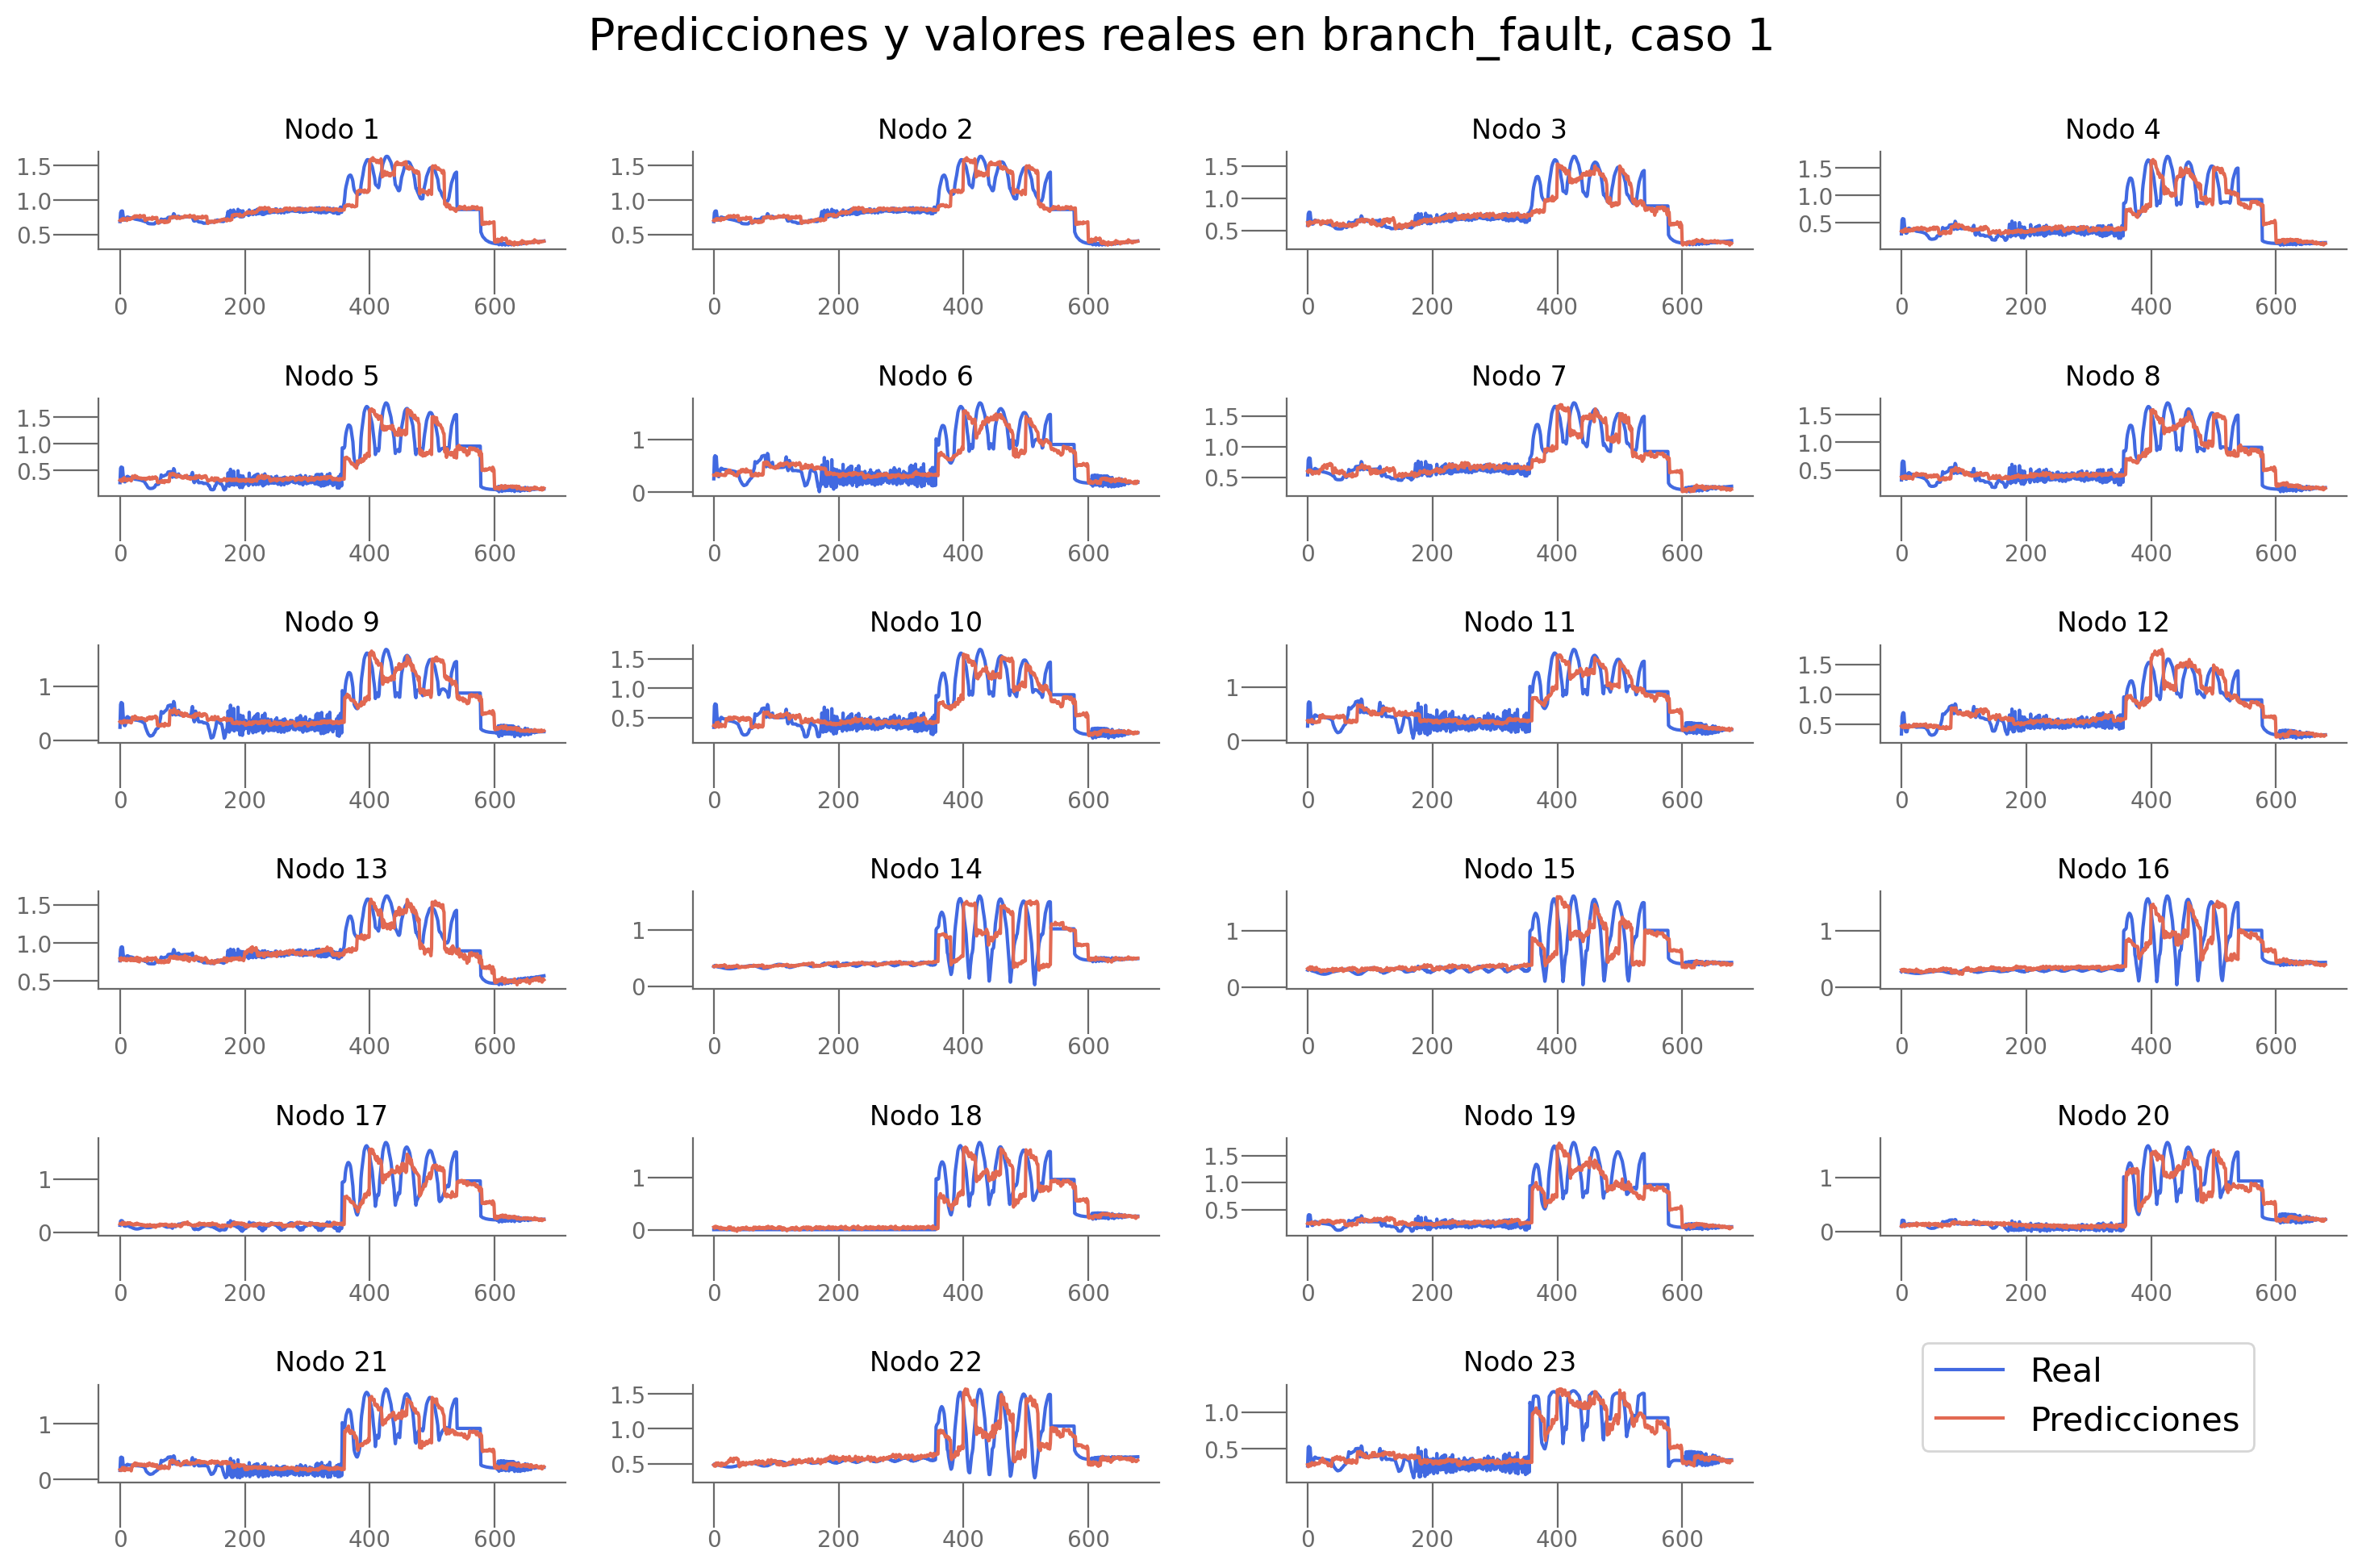

In [28]:
_,_,_, predictions_brf_ajuste,real_brf_ajuste = trainer_brf.test()
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 1, n_div_brf, problem_brf)

In [29]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params = params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01155095 0.00907443 0.01350776 0.02466182 0...  0.584785   0.029613   
1  [0.01080354 0.00768281 0.0111787  0.02304618 0... -2.690716   0.028298   
2  [[0.004804677, 0.008133996, 0.015444276, 0.013... -2.772604   0.026632   

   Loss_final  
0    0.020435  
1    0.020590  
2    0.018094  

==================== RES

### Branch trip

In [30]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [31]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5




#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1895 | Eval Loss: 0.0378 | Eval R2: -17.1385 | 
Epoch 2/30 | Train Loss: 0.0288 | Eval Loss: 0.0233 | Eval R2: -9.9745 | 
Epoch 3/30 | Train Loss: 0.0170 | Eval Loss: 0.0117 | Eval R2: -5.5399 | 
Epoch 4/30 | Train Loss: 0.0103 | Eval Loss: 0.0088 | Eval R2: -4.1234 | 
Epoch 5/30 | Train Loss: 0.0088 | Eval Loss: 0.0098 | Eval R2: -6.8318 | 
Epoch 6/30 | Train Loss: 0.0077 | Eval Loss: 0.0073 | Eval R2: -4.2029 | 
Epoch 7/30 | Train Loss: 0.0084 | Eval Loss: 0.0088 | Eval R2: -5.4142 | 
Epoch 8/30 | Train Loss: 0.0069 | Eval Loss: 0.0055 | Eval R2: -2.2495 | 
Epoch 9/30 | Train Loss: 0.0056 | Eval Loss: 0.0057 | Eval R2: -2.9410 | 
Epoch 10/30 | Train Loss: 0.0057 | Eval Loss: 0.0057 | Eval R2: -2.4295 | 
Epoch 11/30 | Train Loss: 0.0053 | Eval Loss: 0.0056 | Eval R2: -2.9680 | 
Epoch 12/30

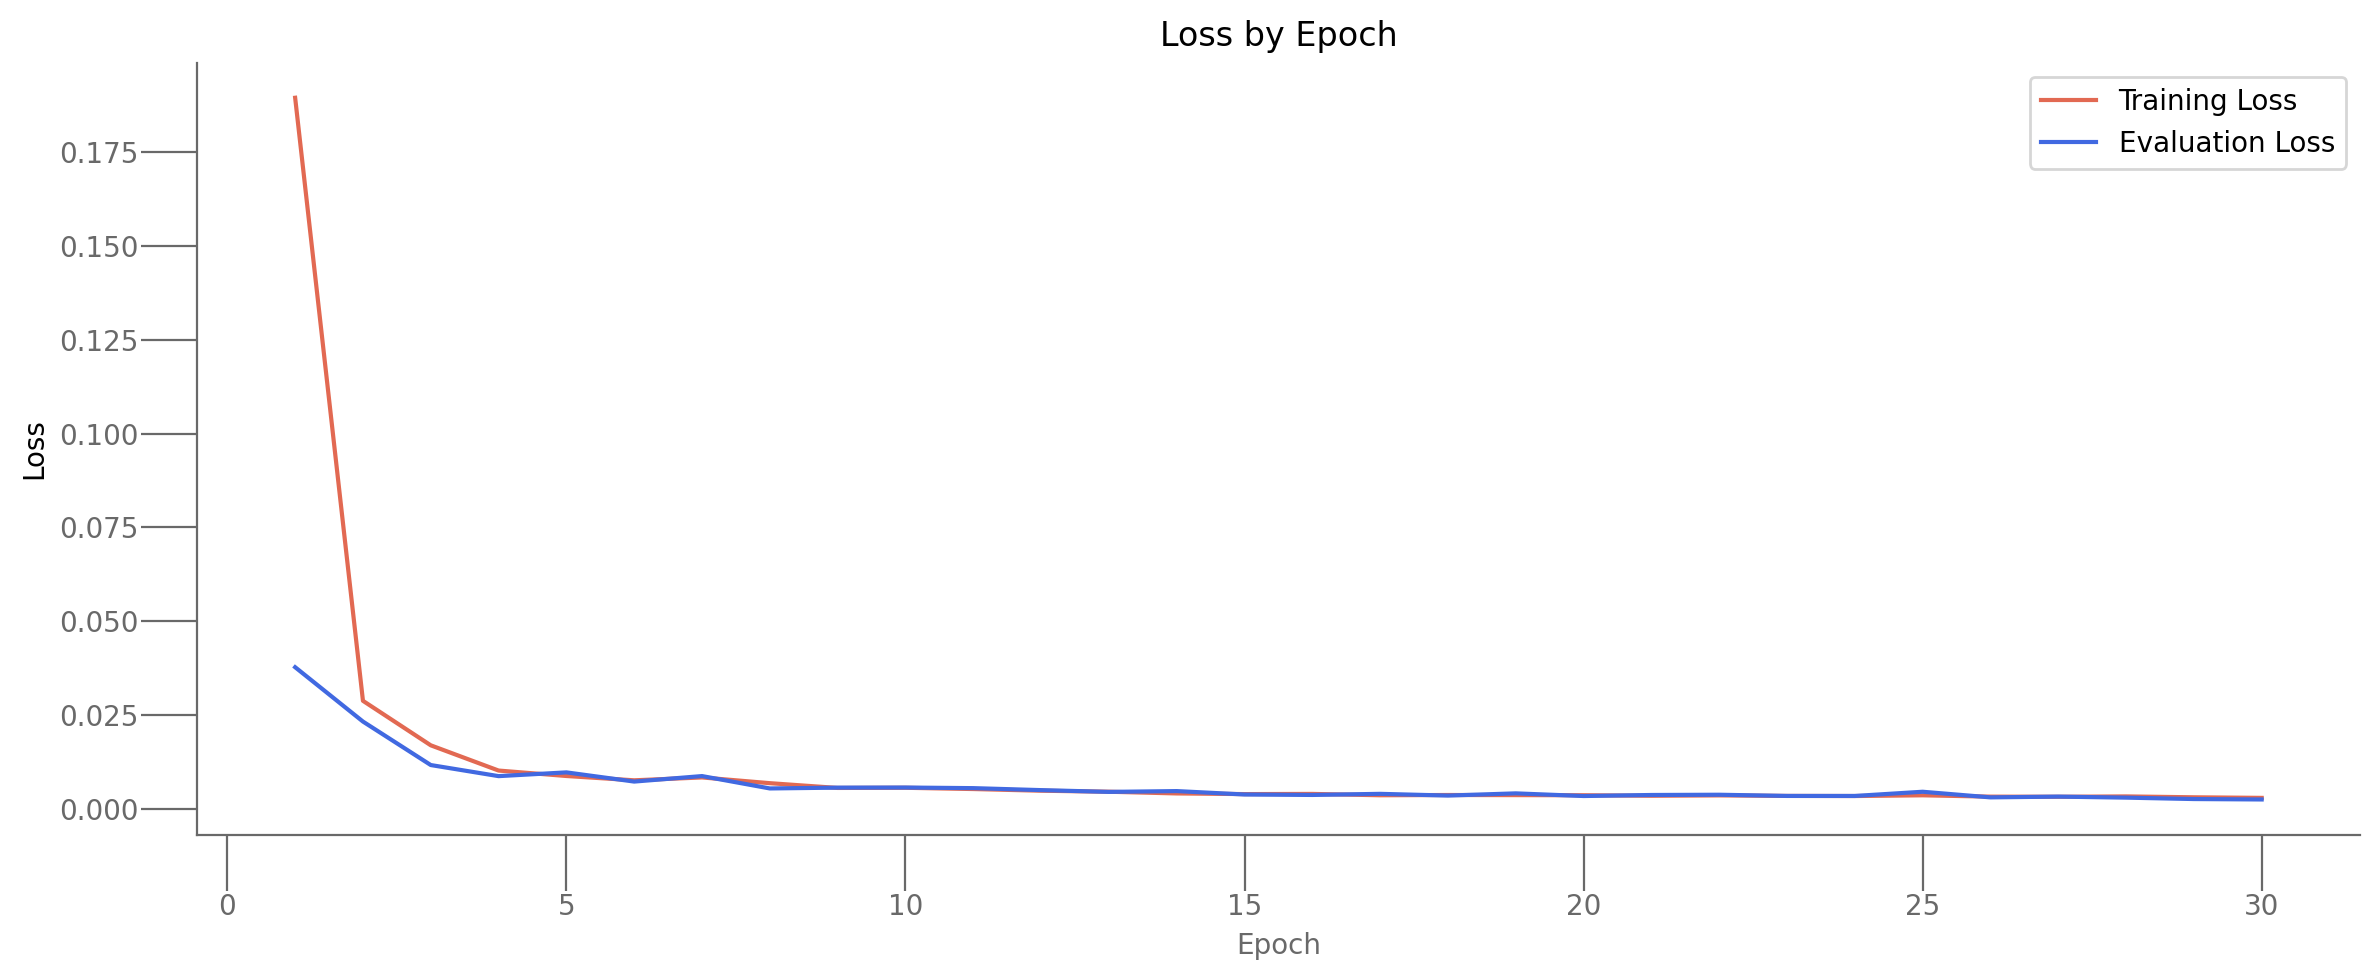


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.003218, test r2score -0.673908


In [32]:

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")


trainer_brt = TrainerDryGrEncoder(model, dataset_brt, device, f"./results/{problem_brt}", dataloader_params2)

losses,eval_losses, r2scores = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_brt.test()


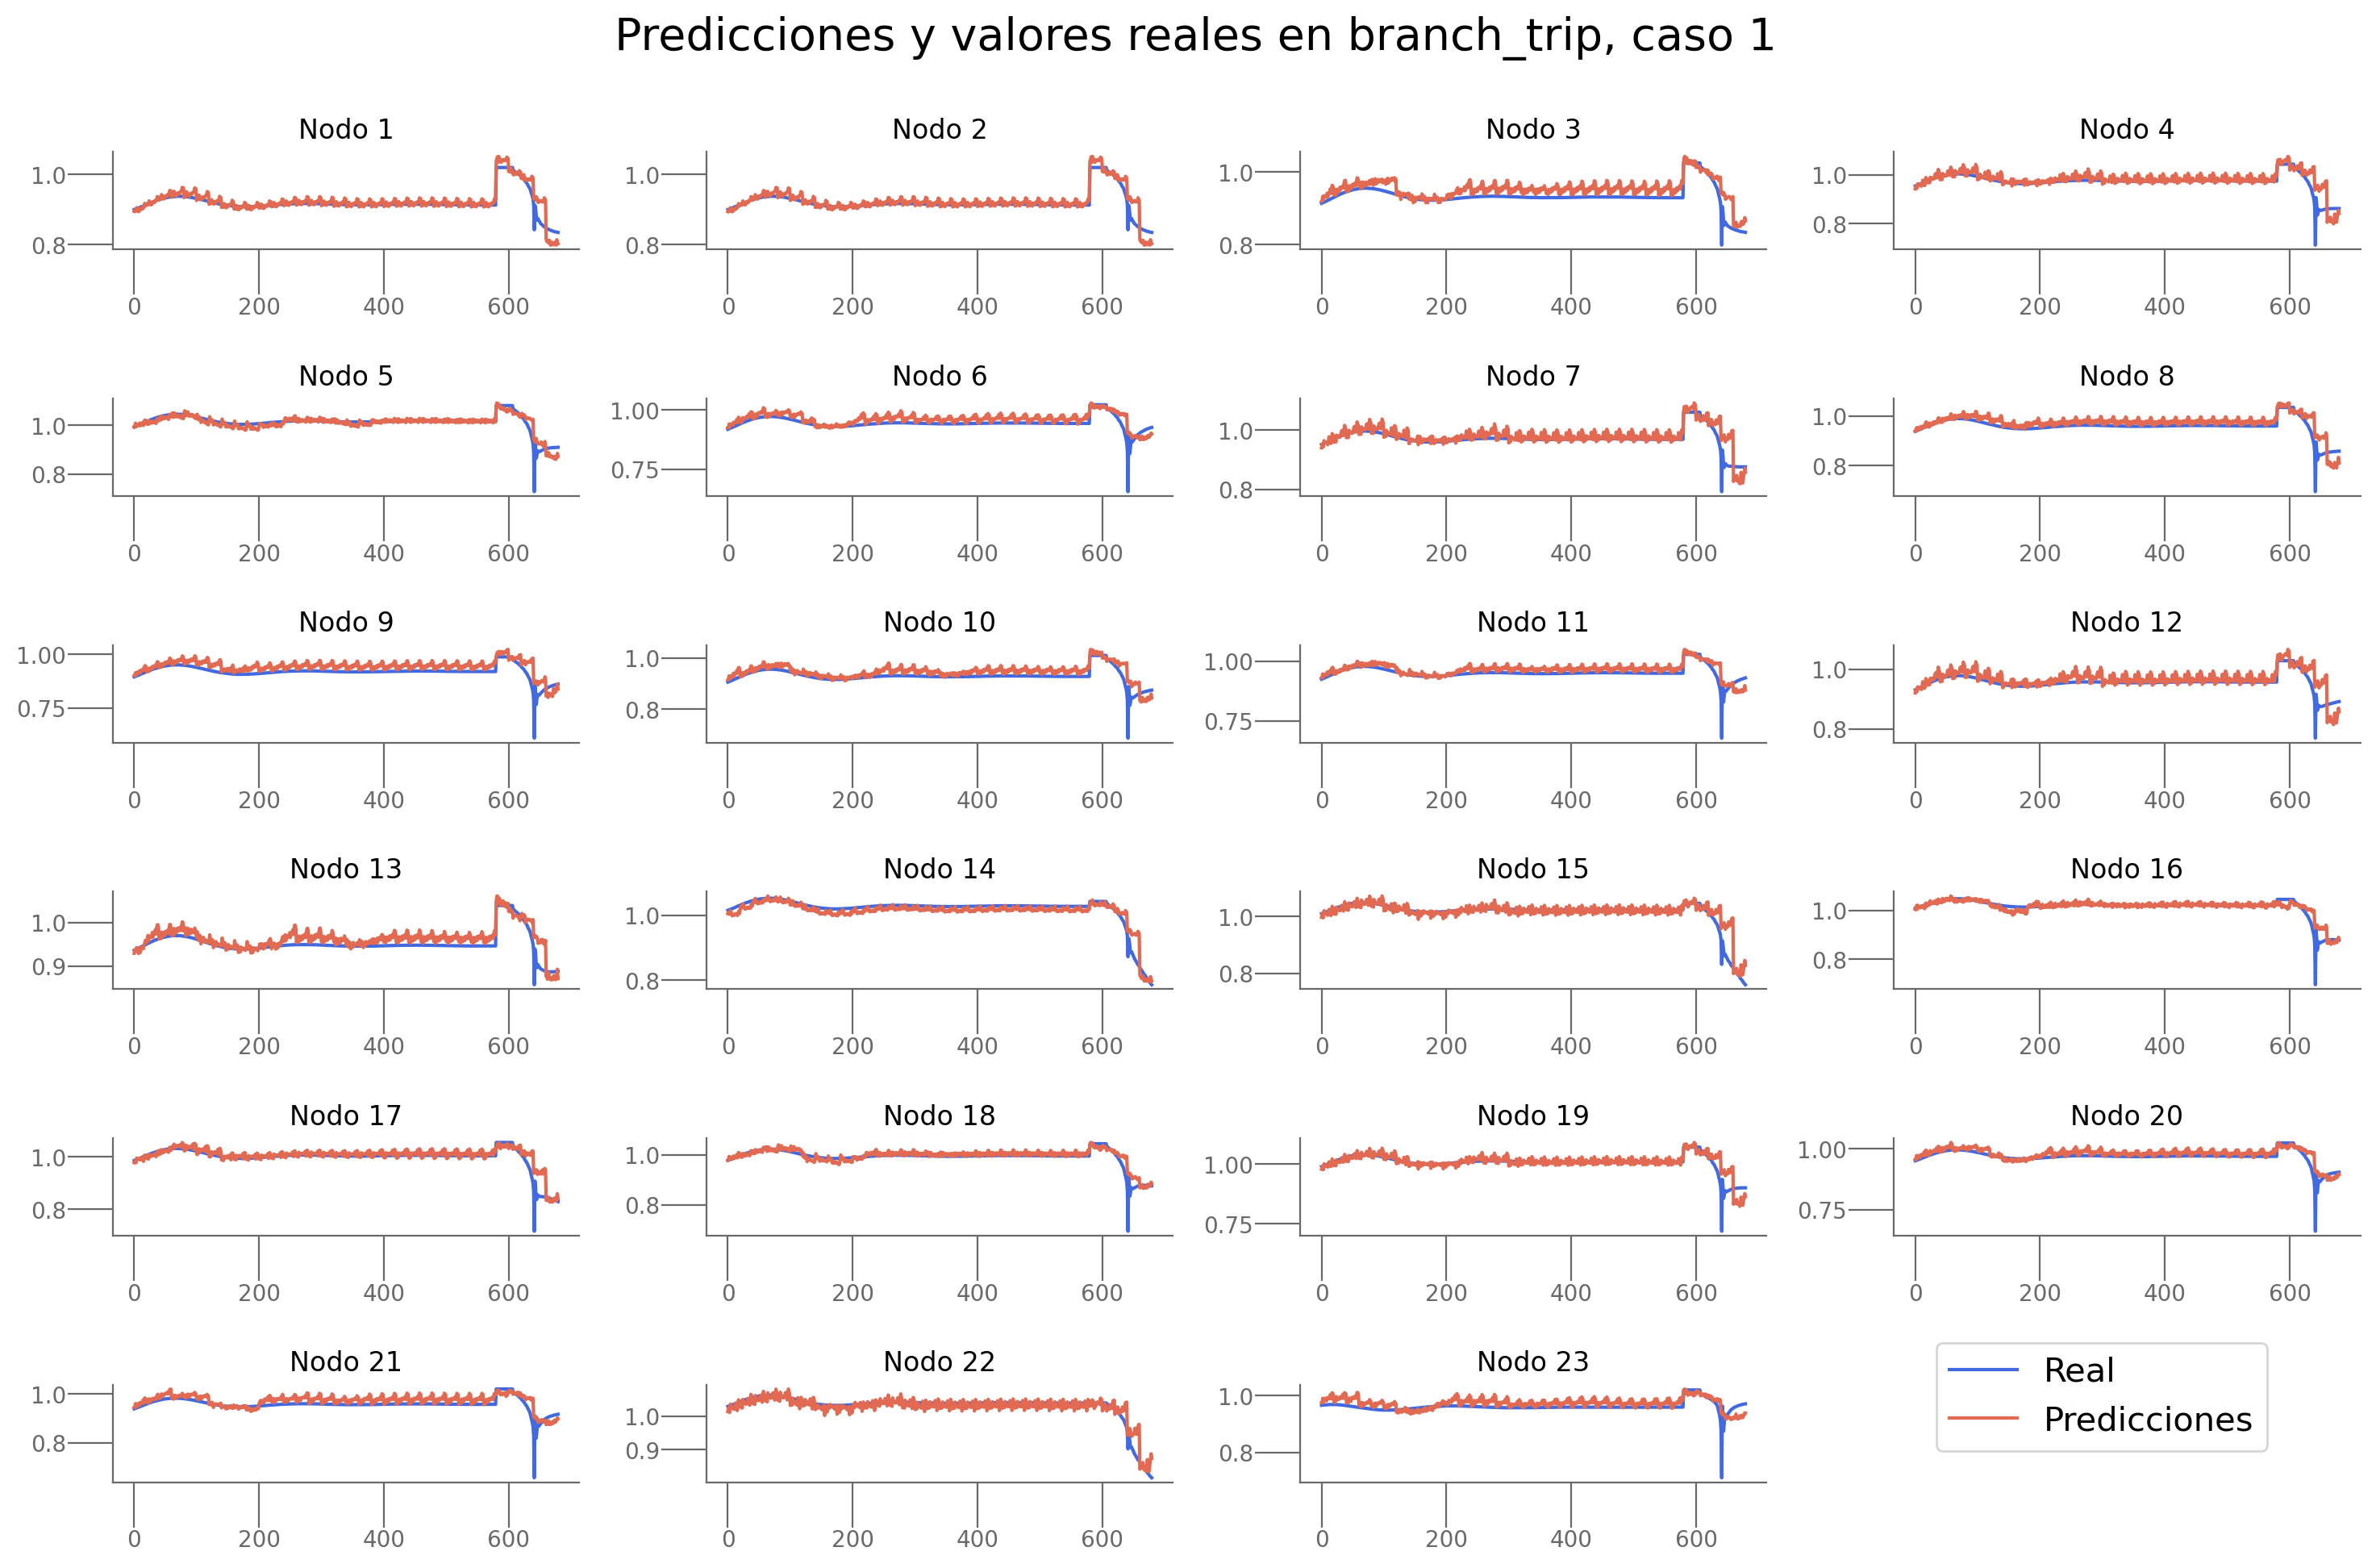

In [33]:
plot_predictions(predictions, real, n_target, 1, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [34]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

trainer_brt,params_brt, resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1894 | Eval Loss: 0.0379 | Eval R2: -17.1493 | 
Epoch 2/30 | Train Loss: 0.0289 | Eval Loss: 0.0227 | Eval R2: -10.2012 | 
Epoch 3/30 | Train Loss: 0.0169 | Eval Loss: 0.0122 | Eval R2: -6.9902 | 
Epoch 4/30 | Train Loss: 0.0104 | Eval Loss: 0.0120 | Eval R2: -8.0485 | 
Epoch 5/30 | Train Loss: 0.0083 | Eval Loss: 0.0077 | Eval R2: -3.8242 | 
Epoch 6/30 | Train Loss: 0.0071 | Eval Loss: 0.0084 | Eval R2: -5.0509 | 
Epoch 7/30 | Train Loss: 0.0073 | Eval Loss: 0.0064 | Eval R2: -2.8308 | 
Epoch 8/30 | Train Loss: 0.0065 | Eval Loss: 0.0062 | Eval R2: -2.9280 | 
Epoch 9/30 | Train Loss: 0.0057 | Eval Loss: 0.0057 | Eval R2: -2.2654 | 
Epoch 10/30 | Train Loss: 0.0057 | Eval Loss: 0.0059 | Eval R2: -3.2287 | 
Epoch 11/30 | Train Loss: 0.0049 | Eval Loss: 0.0054 | Eval R2: -2.8081 | 
Epoch 12/3

 12%|█▎        | 1/8 [09:16<1:04:57, 556.79s/it]

preds:  (1, 23, 20)
test loss: 0.004017, test r2score -1.605640
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'Loss_final': 0.0033358540385961533, 'R2_eval': -1.2664660215377808, 'Loss_eval': 0.003307450795546174, 'R2_tst': -1.605640101729279, 'Loss_tst': 0.004017207771539688, 'Loss_nodes': [[0.0018812981434166431, 0.0022341387812048197, 0.0025602870155125856, 0.0026996820233762264, 0.002453646156936884, 0.0028425168711692095, 0.003128669923171401, 0.00348259205929935, 0.0035858715418726206, 0.0035526095889508724, 0.0036144570913165808, 0.004470362793654203, 0.004292364697903395, 0.004483067896217108, 0.005260220263153315, 0.005293159279972315, 0.006181119941174984, 0.0058633629232645035, 0.006047990173101425, 0.0064167301170527935]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2423 | Eval Loss: 0.0434 | Eva

 25%|██▌       | 2/8 [19:53<1:00:22, 603.79s/it]

preds:  (1, 23, 20)
test loss: 0.002719, test r2score -0.549398
Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'Loss_final': 0.0026771037373691797, 'R2_eval': -0.48682621121406555, 'Loss_eval': 0.0024250007700175047, 'R2_tst': -0.549397591832536, 'Loss_tst': 0.002719039795920253, 'Loss_nodes': [[0.0007515301113016903, 0.001001525204628706, 0.001174527802504599, 0.0013766876654699445, 0.0012547364458441734, 0.00136766885407269, 0.0016694830264896154, 0.0020932666957378387, 0.0019950333517044783, 0.0020146374590694904, 0.002427493454888463, 0.002734218258410692, 0.0030009858310222626, 0.0032739806920289993, 0.004091917537152767, 0.0038925029803067446, 0.0049040662124753, 0.004717453382909298, 0.00507093733176589, 0.005568139720708132]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2033 | Eval Loss: 0.0344 | Eval

 38%|███▊      | 3/8 [33:56<59:25, 713.03s/it]  

preds:  (1, 23, 20)
test loss: 0.003284, test r2score -0.711113
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'Loss_final': 0.0028960604686290026, 'R2_eval': -0.5234414339065552, 'Loss_eval': 0.0028438474982976913, 'R2_tst': -0.7111132161556386, 'Loss_tst': 0.003283928846940398, 'Loss_nodes': [[0.0012475688708946109, 0.0014900167006999254, 0.001614024629816413, 0.0017807435942813754, 0.0018666625255718827, 0.0019294306403025985, 0.00228674104437232, 0.0029545805882662535, 0.0027796716894954443, 0.0026660701259970665, 0.0031053798738867044, 0.003406231990084052, 0.003696632804349065, 0.003881563665345311, 0.004684293642640114, 0.0043779038824141026, 0.005389657337218523, 0.00521574541926384, 0.005496291909366846, 0.00580937135964632]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2403 | Eval Loss: 0.0438 | Eva

 50%|█████     | 4/8 [48:02<51:01, 765.35s/it]

preds:  (1, 23, 20)
test loss: 0.002838, test r2score -0.683715
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'Loss_final': 0.0027958217542618513, 'R2_eval': -0.6573030352592468, 'Loss_eval': 0.0027853837236762047, 'R2_tst': -0.6837147847685314, 'Loss_tst': 0.0028379654977470636, 'Loss_nodes': [[0.0009839619742706418, 0.001257672323845327, 0.0013869085814803839, 0.001446801470592618, 0.0015040729194879532, 0.0015645520761609077, 0.0018438970437273383, 0.0022418429143726826, 0.002117530908435583, 0.0021864608861505985, 0.002482004463672638, 0.002914282027631998, 0.0031408981885761023, 0.003378679510205984, 0.0041951765306293964, 0.0039291419088840485, 0.004996557720005512, 0.004796233028173447, 0.0049546221271157265, 0.0054380204528570175]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1885 | Eval Loss: 0.0385

 62%|██████▎   | 5/8 [57:17<34:29, 689.74s/it]

preds:  (1, 23, 20)
test loss: 0.003354, test r2score -0.965708
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'Loss_final': 0.003054790897294879, 'R2_eval': -0.8590916991233826, 'Loss_eval': 0.002915115561336279, 'R2_tst': -0.9657077543673407, 'Loss_tst': 0.0033538455609232187, 'Loss_nodes': [[0.0012888931669294834, 0.001577707240357995, 0.0017077315133064985, 0.0016889177495613694, 0.0018780831014737487, 0.0019553417805582285, 0.002238139044493437, 0.002720181830227375, 0.0027105200570076704, 0.0027387100271880627, 0.0031036410946398973, 0.003431358840316534, 0.003801357466727495, 0.004022775683552027, 0.004789710510522127, 0.004714012145996094, 0.005553066730499268, 0.00547735346481204, 0.005714755039662123, 0.005964659620076418]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2415 | Eval Loss: 0.0436 | Ev

 75%|███████▌  | 6/8 [1:06:10<21:12, 636.40s/it]

preds:  (1, 23, 20)
test loss: 0.003444, test r2score -1.015286
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'Loss_final': 0.0038926086854189634, 'R2_eval': -0.6446019411087036, 'Loss_eval': 0.0029496813658624887, 'R2_tst': -1.0152861025172615, 'Loss_tst': 0.0034439240116626024, 'Loss_nodes': [[0.0014168994966894388, 0.0017930299509316683, 0.001966141164302826, 0.0019992778543382883, 0.0019526395481079817, 0.0022026498336344957, 0.002404129132628441, 0.002892271149903536, 0.002799064852297306, 0.0028928054962307215, 0.0031696355435997248, 0.00367741659283638, 0.0037701318506151438, 0.004080252721905708, 0.004745613783597946, 0.004675442818552256, 0.005563719198107719, 0.005284126847982407, 0.005621427670121193, 0.00597180612385273]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1985 | Eval Loss: 0.0330 | E

 88%|████████▊ | 7/8 [1:17:00<10:40, 640.81s/it]

preds:  (1, 23, 20)
test loss: 0.003583, test r2score -0.950105
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'Loss_final': 0.0028988986741751432, 'R2_eval': -0.815889835357666, 'Loss_eval': 0.003257819451391697, 'R2_tst': -0.9501049139113689, 'Loss_tst': 0.0035833397414535284, 'Loss_nodes': [[0.0014194020768627524, 0.0017263888148590922, 0.002096387092024088, 0.0019371232483536005, 0.0023035898339003325, 0.0021180473268032074, 0.0026129886973649263, 0.0030249999836087227, 0.0028596590273082256, 0.0030177512671798468, 0.0033814064227044582, 0.0036321773659437895, 0.004060244187712669, 0.004088538698852062, 0.005053365603089333, 0.004783528856933117, 0.0058364528231322765, 0.005703674163669348, 0.005703101400285959, 0.006307979580014944]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2400 | Eval Loss: 0.0447

100%|██████████| 8/8 [1:28:20<00:00, 662.60s/it]

preds:  (1, 23, 20)
test loss: 0.003406, test r2score -1.245277
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'Loss_final': 0.0031314643565565348, 'R2_eval': -1.1612439155578613, 'Loss_eval': 0.0032054202165454626, 'R2_tst': -1.2452769914979165, 'Loss_tst': 0.0034058280289173126, 'Loss_nodes': [[0.0018085932824760675, 0.0019014463759958744, 0.002160219941288233, 0.0021592737175524235, 0.002135323826223612, 0.0022758126724511385, 0.0025897121522575617, 0.0028591924346983433, 0.0031866906210780144, 0.002737032948061824, 0.0031345849856734276, 0.003691423684358597, 0.0034206558484584093, 0.0037477125879377127, 0.004423048347234726, 0.00453378027305007, 0.005362543743103743, 0.0049777645617723465, 0.005317343398928642, 0.005694412626326084]]}


In [35]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.002719, test r2score -0.549398


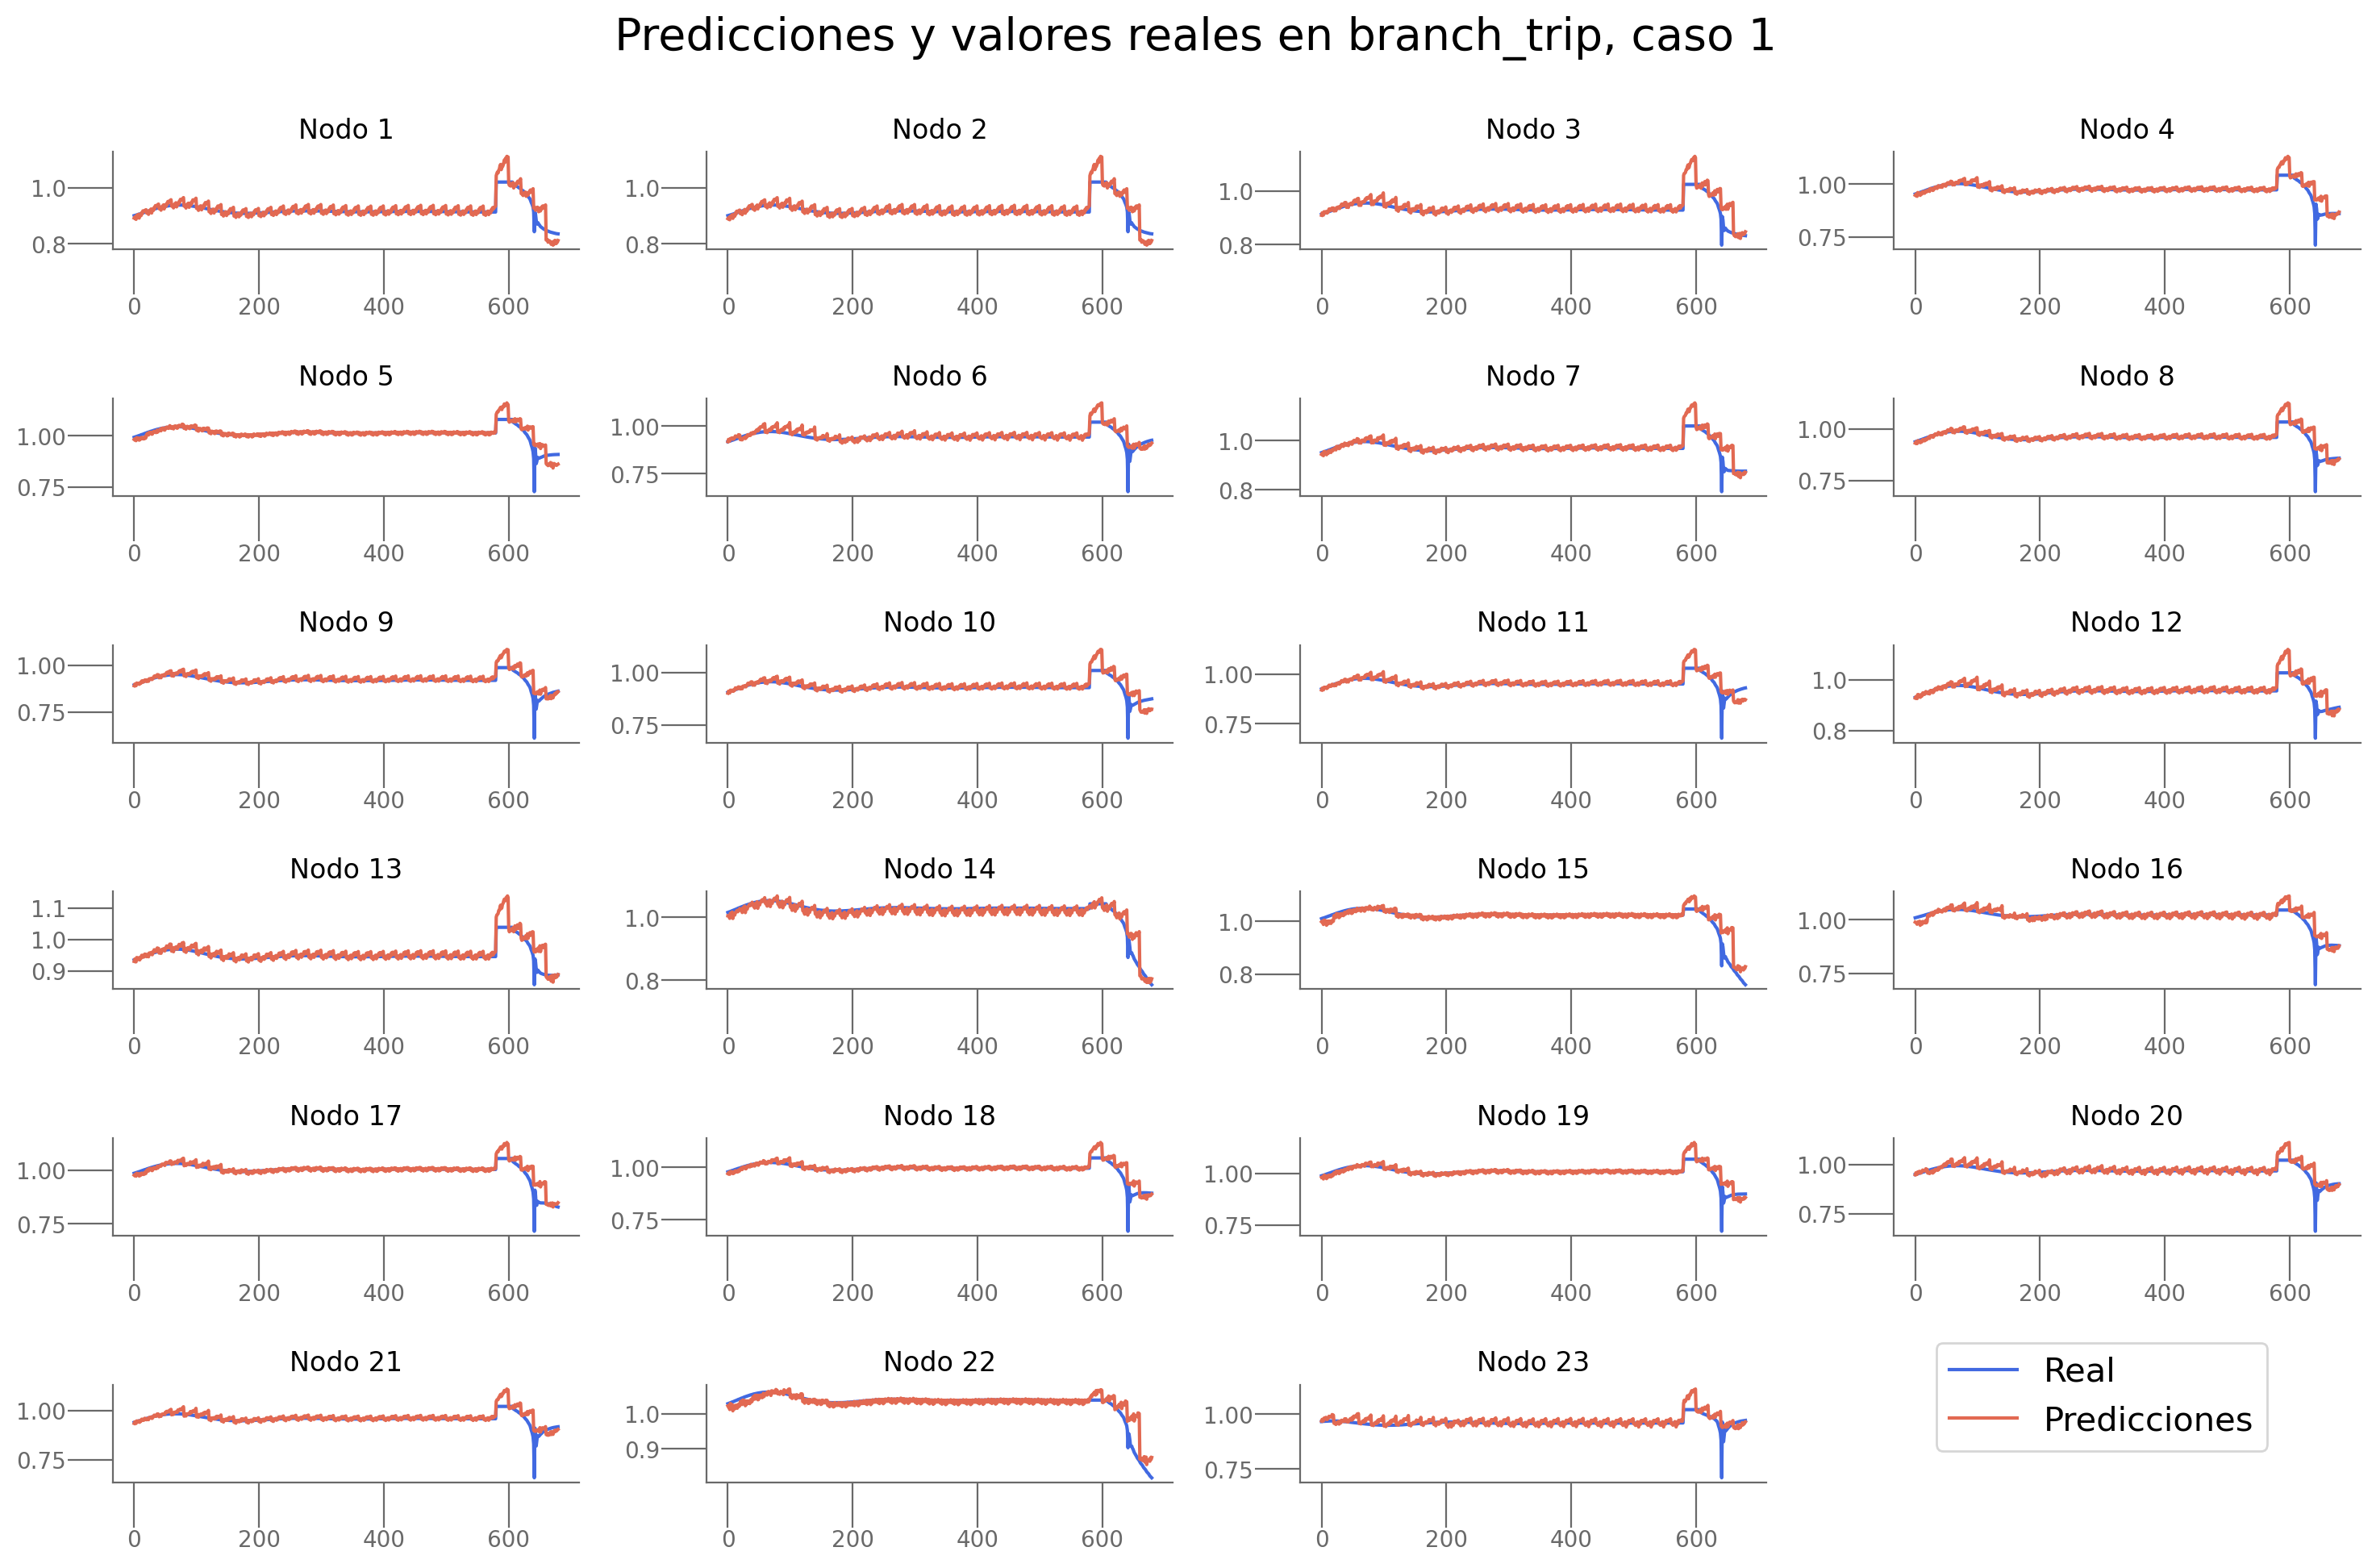

In [36]:
_,_,_, predictions_brt_ajuste,real_brt_ajuste = trainer_brt.test()
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [37]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params = params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0036937  0.00202668 0.00244704 0.00374463 0...  0.435549   0.003684   
1  [0.01389701 0.00177465 0.00324512 0.0049619  0... -1.577386   0.004085   
2  [[0.0007515301, 0.0010015252, 0.0011745278, 0.... -0.486826   0.002425   

   Loss_final  
0    0.003296  
1    0.004827  
2    0.002677  

==================== RES